In [1]:
import os
os.chdir(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src'))

In [2]:
from pkg.utils.utils import *
from pkg.utils.traj_utils import *

In [3]:
import matplotlib.pyplot as plt

In [4]:
from pkg.controller.combined_robot import *
from pkg.project_config import *
rospy.init_node("robot_test")
crob = CombinedRobot(robots_on_scene=[
    RobotConfig(0, RobotType.indy7, ((0.3,-0.4,0), (0,0,np.pi/2)),
                INDY_IP),
    RobotConfig(1, RobotType.panda, ((-0.3,-0.4,0), (0,0,np.pi/2)),
                "{}/{}".format(PANDA_REPEATER_IP, PANDA_ROBOT_IP))]
              , connection_list=[True, True])

connection_list
[True, True]
Connect: Server IP (192.168.0.63)


In [5]:
indy = crob.robot_dict["indy0"]
panda = crob.robot_dict["panda1"]
with indy:
    indy.set_joint_vel_level(1)
    indy.set_task_vel_level(1)
crob.grasp_by_dict({"indy0":False, "panda1": False})

Connect: Server IP (192.168.0.63)
grasp_dict
{'indy0': False, 'panda1': False}
grasp_seq
[('indy0', False), ('panda1', False)]
Connect: Server IP (192.168.0.63)


In [6]:
# trajectory_list = load_json("traj.json")
# trajectory = np.array(trajectory_list)
# # trajectory = trajectory[:,6:]

In [7]:
trajectory_list = []
for i_s in range(10):
    trajectory_list.append(np.array(load_json("traj%02d.json"%(i_s))))

## WARN: MOVE ROBOT ONCE

In [8]:
crob.joint_make_sure(crob.home_pose)

Connect: Server IP (192.168.0.63)


In [9]:
indy.stop_tracking()

{'stop': True}

In [23]:
trajectory = trajectory_list[0]
vel_scale=0.5
acc_scale=0.07

In [24]:
crob.move_joint_wp(trajectory, vel_scale=vel_scale, acc_scale=acc_scale)
time.sleep(1)

In [25]:
crob.move_joint_wp(np.array(list(reversed(trajectory))), vel_scale=vel_scale, acc_scale=acc_scale)
time.sleep(1)

## WARN: MOVE ROBOT ALL TRAJ

In [26]:
crob.joint_make_sure(crob.home_pose)

Connect: Server IP (192.168.0.63)


In [27]:
indy.stop_tracking()

{'stop': True}

In [28]:
vel_scale=0.5
acc_scale=0.07
for trajectory in trajectory_list:
    crob.move_joint_wp(trajectory, vel_scale=vel_scale, acc_scale=acc_scale)
    time.sleep(1)

## TEST TRAJECTORY CALCULATION

In [20]:
trajectory = trajectory_list[0]
vel_scale=0.3
acc_scale=0.07

In [21]:
for name, rconfig in zip(crob.robot_names, crob.robots_on_scene):
    _type = rconfig.type
    robot = crob.robot_dict[name]
    traj_cur_rbt = trajectory[:,crob.idx_dict[name]]
    diff_abs_arr = np.abs(traj_cur_rbt - traj_cur_rbt[0:1, :])
    if np.max(diff_abs_arr) > 1e-3:
        dt_step = 1.0/crob.robot_dict[name].traj_freq
        vel_limits = np.multiply(RobotSpecs.get_vel_limits(_type), vel_scale)
        acc_limits = np.multiply(RobotSpecs.get_acc_limits(_type), acc_scale)
        traj_tot = calc_safe_cubic_traj(dt_step, traj_cur_rbt, vel_limits, acc_limits)
        T_list, Q_list, _ = get_safe_cubics(dt_step, traj_cur_rbt, vel_lim=vel_limits, acc_lim=acc_limits)
        t_all, traj_all = get_traj_all(dt_step, T_list, Q_list)

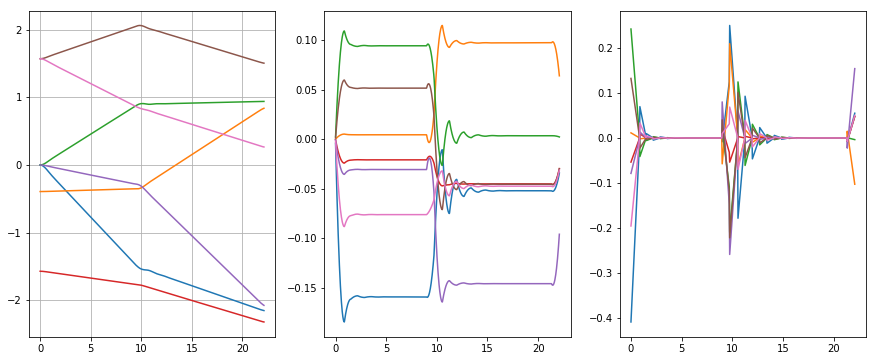

In [22]:
traj_all = np.array(traj_all)

plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.plot(np.arange(len(traj_all)).astype(np.float)*dt_step, traj_all)
# plt.plot(T_accum, Q_list,'x')
plt.grid(True)

plt.subplot(1,3,2)
v_tot = (traj_all[1:]-traj_all[:-1])/dt_step
plt.plot(np.arange(len(v_tot)).astype(np.float)*dt_step, v_tot)

plt.subplot(1,3,3)
a_tot = (v_tot[1:]-v_tot[:-1])/dt_step
plt.plot(np.arange(len(a_tot)).astype(np.float)*dt_step, a_tot)